
Kruskal-Wallis-Test für rücktransformierte Daten:
         Feature   H-statistic        p-value
15   ULICHTVERH  38866.758804   0.000000e+00
0         UJAHR  24911.009650   0.000000e+00
3    UWOCHENTAG  22892.455602   0.000000e+00
2       USTUNDE  21446.593442   0.000000e+00
12    YGCSWGS84  17655.348686   0.000000e+00
11    XGCSWGS84  14180.020220   0.000000e+00
1        UMONAT  13603.067412   0.000000e+00
16  USTRZUSTAND   4263.528867   0.000000e+00
7       IstFuss    784.852059  3.784315e-164
5        IstRad    760.421505  6.948985e-159
14        UTYP1    334.053131   2.287248e-67
13         UART    300.896336   2.653926e-60
4    UKATEGORIE    225.651021   2.461343e-44
6        IstPKW    164.629995   1.718930e-31
8       IstKrad    131.586454   1.326494e-24
9       IstGkfz    121.185425   1.886701e-22
10  IstSonstige     85.756997   3.368180e-15


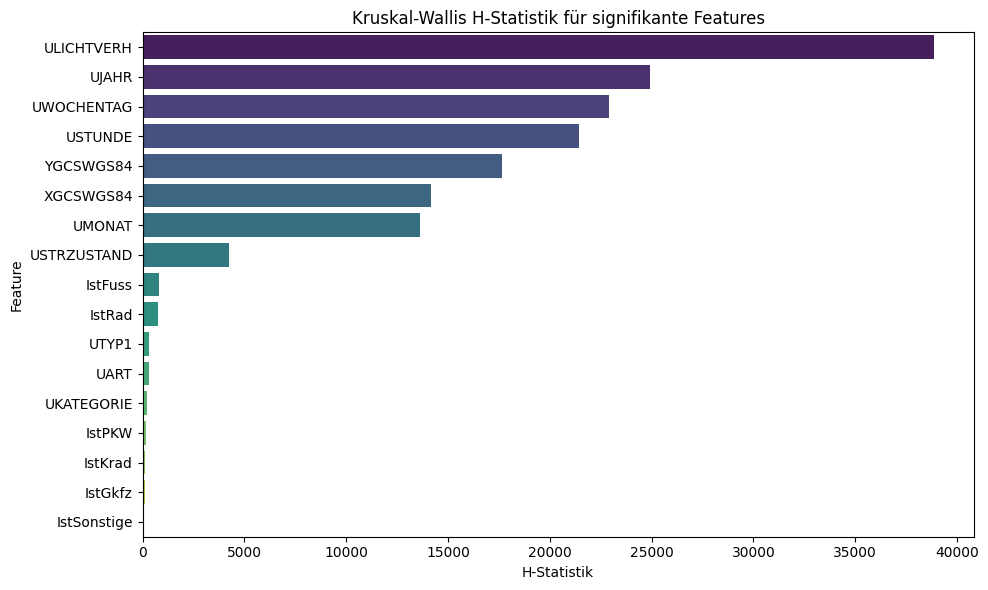

Anzahl der signifikanten Features: 17


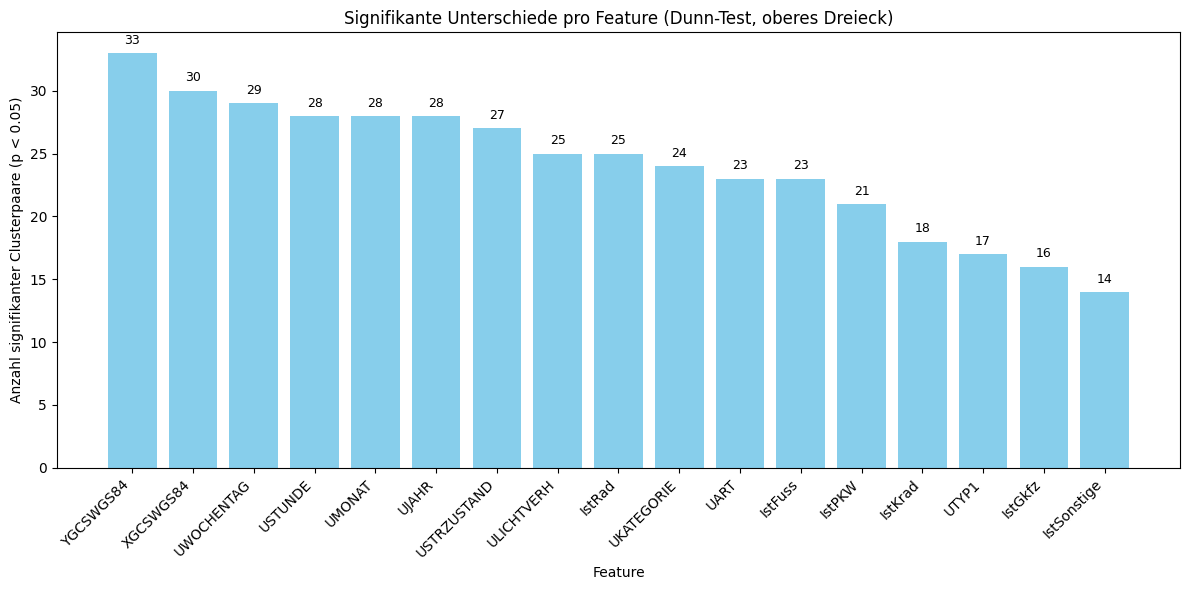

        Feature  Anzahl eindeutiger signifikanter Clusterpaare
4     YGCSWGS84                                             33
5     XGCSWGS84                                             30
2    UWOCHENTAG                                             29
3       USTUNDE                                             28
6        UMONAT                                             28
1         UJAHR                                             28
7   USTRZUSTAND                                             27
0    ULICHTVERH                                             25
9        IstRad                                             25
12   UKATEGORIE                                             24
11         UART                                             23
8       IstFuss                                             23
13       IstPKW                                             21
14      IstKrad                                             18
10        UTYP1                                        

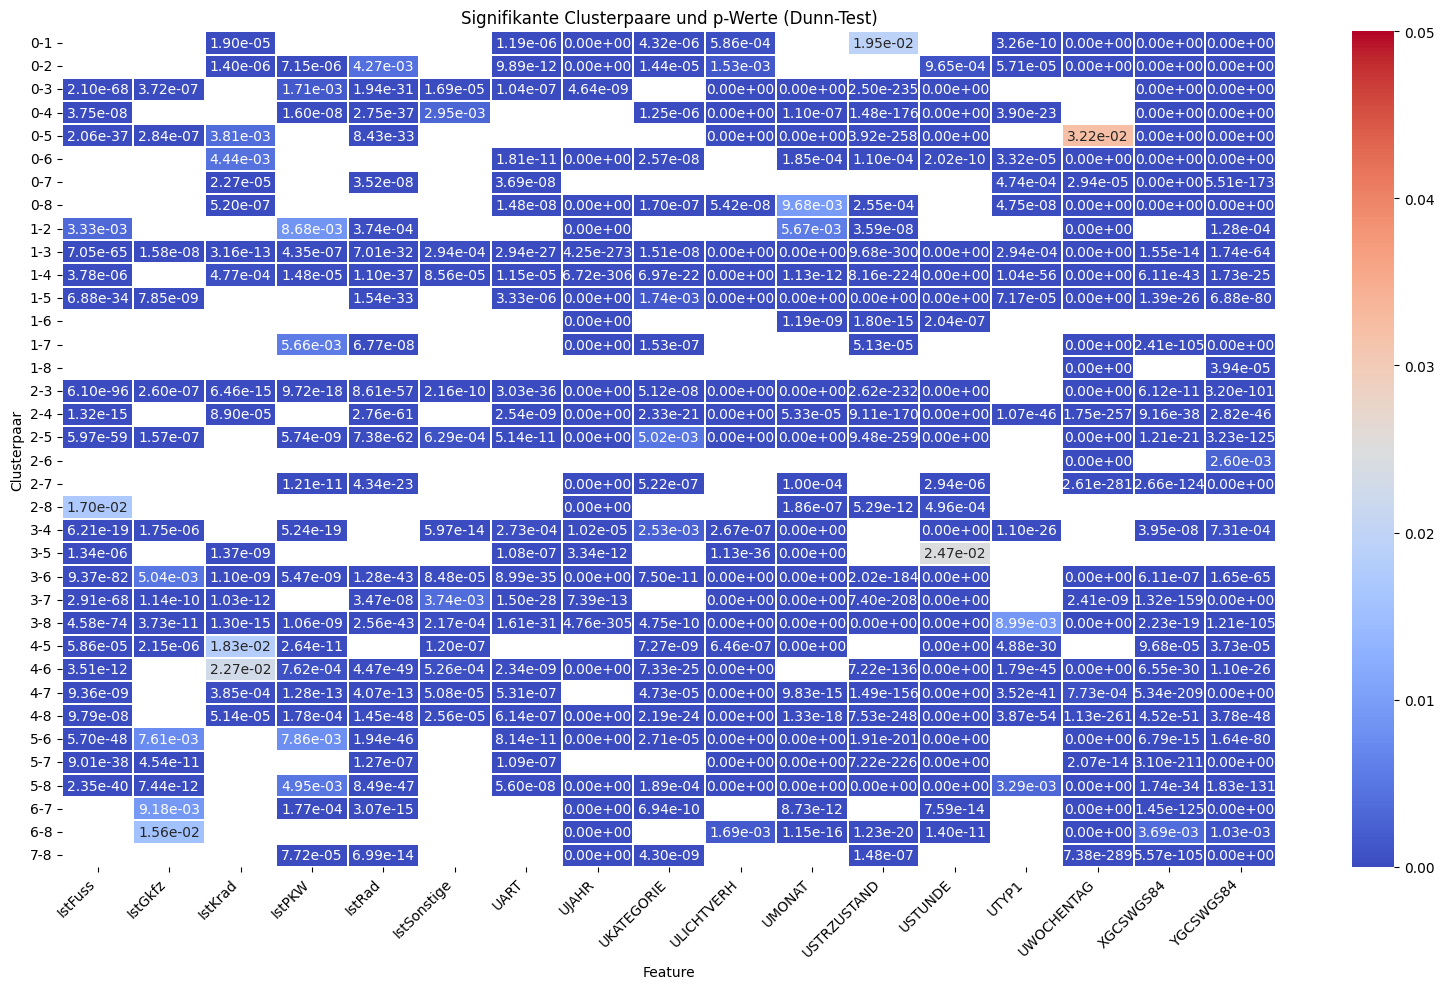

In [6]:
# -*- coding: utf-8 -*-
"""
Auswertung von K-Means-Clustern mit Kruskal-Wallis- und Dunn-Test (angepasst an Code 1)
"""
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from scipy.stats import kruskal
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp

# -------------------------------------------
# 1. Daten laden
# -------------------------------------------
df_encoded = pd.read_csv("k_means_ohneBEZ_LOR_encoded_data.csv")
kmeans = joblib.load('kmeans_model.pkl')
df_encoded['Cluster_Original'] = kmeans.predict(df_encoded.drop(columns=['Cluster_Original'], errors='ignore'))

std_scaler = joblib.load("k_means_std_scaler.pkl")
onehot_encoder = joblib.load("k_means_onehot_encoder.pkl")

# -------------------------------------------
# 2. Variablen definieren
# -------------------------------------------
numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']
coordinate_vars = ['XGCSWGS84', 'YGCSWGS84']
ordinal_vars = ['UKATEGORIE']
nominal_vars = ['UART', 'UTYP1', 'ULICHTVERH', 'USTRZUSTAND']
binary_vars = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']

# -------------------------------------------
# 3. Rücktransformation der Daten
# -------------------------------------------
df_encoded[numerical_vars + coordinate_vars] = std_scaler.inverse_transform(df_encoded[numerical_vars + coordinate_vars])
onehot_columns = onehot_encoder.get_feature_names_out(nominal_vars)
df_nominal = pd.DataFrame(onehot_encoder.inverse_transform(df_encoded[onehot_columns]), columns=nominal_vars)
df_encoded = df_encoded.drop(columns=onehot_columns)
df_encoded = pd.concat([df_encoded, df_nominal], axis=1)

# -------------------------------------------
# 4. Kruskal-Wallis-Test durchführen
# -------------------------------------------
num_clusters = df_encoded['Cluster_Original'].nunique()
kruskal_stats = []
p_values = []

for feature in df_encoded.columns:
    if feature != 'Cluster_Original':
        groups = [df_encoded[df_encoded['Cluster_Original'] == c][feature] for c in range(num_clusters)]
        stat, p_val = kruskal(*groups)
        kruskal_stats.append(stat)
        p_values.append(p_val)

kruskal_df = pd.DataFrame({
    'Feature': df_encoded.columns[df_encoded.columns != 'Cluster_Original'],
    'H-statistic': kruskal_stats,
    'p-value': p_values
}).sort_values(by='H-statistic', ascending=False)

print("\nKruskal-Wallis-Test für rücktransformierte Daten:\n", kruskal_df)
os.makedirs("output/plots", exist_ok=True)
kruskal_df.to_csv("Kruskal-Wallis_results.csv", index=False)

# -------------------------------------------
# 5. Visualisierung signifikanter Merkmale
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='H-statistic', y='Feature', data=kruskal_df[kruskal_df['p-value'] < 0.05], palette='viridis')
plt.title('Kruskal-Wallis H-Statistik für signifikante Features')
plt.xlabel('H-Statistik')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("output/plots/Kruskal-Wallis_Signifikante_Features.png", dpi=100, bbox_inches="tight")
plt.show()

significant_features = kruskal_df[kruskal_df['p-value'] < 0.05]['Feature']
print(f"Anzahl der signifikanten Features: {len(significant_features)}")

# -------------------------------------------
# 6. Dunn-Test für signifikante Merkmale
# -------------------------------------------
dunn_results = {}
for feature in significant_features:
    dunn_results[feature] = sp.posthoc_dunn(
        df_encoded, val_col=feature, group_col='Cluster_Original', p_adjust='bonferroni')

with pd.ExcelWriter("Dunn_Test_results.xlsx") as writer:
    for feature, df in dunn_results.items():
        df.to_excel(writer, sheet_name=feature[:31])

# -------------------------------------------
# 7. Visualisierung der Anzahl signifikanter Clusterpaare
# -------------------------------------------
summary_unique = {}
for feature, df in dunn_results.items():
    mask = np.triu(np.ones(df.shape), k=1).astype(bool)
    unique_p_values = df.where(mask)
    count = (unique_p_values < 0.05).sum().sum()
    summary_unique[feature] = count

summary_unique_df = pd.DataFrame(summary_unique.items(), columns=['Feature', 'Anzahl eindeutiger signifikanter Clusterpaare'])
summary_unique_df = summary_unique_df.sort_values(by="Anzahl eindeutiger signifikanter Clusterpaare", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(summary_unique_df['Feature'], summary_unique_df['Anzahl eindeutiger signifikanter Clusterpaare'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Anzahl signifikanter Clusterpaare (p < 0.05)')
plt.title('Signifikante Unterschiede pro Feature (Dunn-Test, oberes Dreieck)')
plt.xticks(rotation=45, ha='right')
# Zahlen über Balken
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("output/plots/Dunn_Test_Signifikante_Features_eindeutig.png", dpi=100, bbox_inches="tight")
plt.show()

print(summary_unique_df)

# -------------------------------------------
# 8. Heatmap signifikanter Clusterpaare
# -------------------------------------------
#rf_features = ['UWOCHENTAG', 'UJAHR', 'UMONAT', 'USTUNDE', 'ULICHTVERH', 'UART', 'IstFuss', 'UKATEGORIE', 'UTYP1', 'IstPKW', 'IstRad']
dunn_results_filtered = {k: v for k, v in dunn_results.items() if k in significant_features.tolist()}

significant_pairs_with_pvalues = []
for feature, df in dunn_results_filtered.items():
    sig = df[df < 0.05].stack()
    for (i, j), pvalue in sig.items():
        if i < j:
            significant_pairs_with_pvalues.append((i, j, feature, pvalue))

significant_pairs_with_pvalues_df = pd.DataFrame(
    significant_pairs_with_pvalues, columns=['Cluster A', 'Cluster B', 'Feature', 'p-value']
)

heatmap_data_pvalues = significant_pairs_with_pvalues_df.pivot_table(
    index=['Cluster A', 'Cluster B'], columns='Feature', values='p-value', aggfunc='min', fill_value=np.nan
)

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data_pvalues, cmap='coolwarm', annot=True, fmt='.2e',
    linewidths=0.1, vmin=0, vmax=0.05
)
plt.xlabel('Feature')
plt.ylabel('Clusterpaar')
plt.title('Signifikante Clusterpaare und p-Werte (Dunn-Test)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("output/plots/Signifikante_Clusterpaare_und_p-Werte_nach_Dunn-Test.png", dpi=100, bbox_inches="tight")
plt.show()

significant_pairs_with_pvalues_df.to_csv("Signifikante_Clusterpaare_mit_p_Werten.csv", index=False)
